# GRU_1 model and fine tuning 

In [1]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import tensorflow as tf
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Ensure plot qualities
plt.rcParams['figure.figsize'] = (12,6)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Adjust DPI for high-resolution figures

In [ ]:
# Google Colab Setup

# Mount Google Drive to access the dataset and save models
from google.colab import drive
drive.mount('/content/drive')

# Check GPU availability and set memory growth (helps with GPU memory allocation)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configured for memory growth.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found!")

Mounted at /content/drive
GPU configured for memory growth.


In [ ]:
# Global environment variables and hyperparameters
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Keep WINDOW_SIZE and PATIENCE fixed, but the other hyperparameters will be tuned
WINDOW_SIZE = 60
PATIENCE = 5
EPOCHS = 100  # Maximum epochs; early stopping will likely kick in earlier

In [ ]:
# Load and preprocess Data
data_path = "/content/drive/My Drive/Colab Notebooks/EMH/data/Bitcoin_data_2024_w_TI_n_Macro.csv"
data = pd.read_csv(data_path, index_col=0, parse_dates=True)

# Only select columns for weak form EMH
data = data.drop(columns=['fear_n_greed_index', 'SP500', 'CPI', 'Gold', 'Nasdaq100', 'VIX', 'Oil'])

print("Dataset loaded with shape:", data.shape)
print(data.describe())
print("Missing values:\n", data.isna().sum())

Dataset loaded with shape: (509414, 14)
                Open           High            Low          Close  \
count  509414.000000  509414.000000  509414.000000  509414.000000   
mean    65867.359665   65886.404966   65848.306193   65867.551180   
std     14578.592420   14582.392179   14574.440115   14578.340474   
min     38515.000000   38525.000000   38505.000000   38508.000000   
25%     59060.000000   59079.000000   59041.000000   59061.000000   
50%     64209.000000   64226.000000   64193.000000   64209.000000   
75%     68985.000000   69001.000000   68967.000000   68986.750000   
max    108293.000000  108364.000000  108204.000000  108276.000000   

           VolumeBTC       Returns%         SMA_20  Volatility_20  \
count  509414.000000  509414.000000  509414.000000  509414.000000   
mean        1.536753       0.000155   65866.600546      67.690602   
std         5.084324       0.075606   14577.923831      60.855268   
min         0.000000      -3.612019   38611.950000       0.000

In [7]:
# Train-validation-test split
train_index = int(len(data) * TRAIN_RATIO)
val_index = train_index + int(len(data) * VAL_RATIO)

train_data = data.iloc[:train_index]
val_data = data.iloc[train_index:val_index]
test_data = data.iloc[val_index:]

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)

assert WINDOW_SIZE < len(train_data), "WINDOW_SIZE is too large for the dataset size!"

print("Train start:", train_data.index[0], "end:", train_data.index[-1])
print("Val start:", val_data.index[0], "end:", val_data.index[-1])
print("Test start:", test_data.index[0], "end:", test_data.index[-1])

Train shape: (356589, 14)
Validation shape: (101882, 14)
Test shape: (50943, 14)
Train start: 2024-01-01 00:34:00 end: 2024-09-12 12:33:00
Val start: 2024-09-12 12:34:00 end: 2024-11-24 18:43:00
Test start: 2024-11-24 18:44:00 end: 2024-12-31 23:59:00


In [8]:
# Scale the data (fit on training data only)
scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# Function to create sequences for time series forecasting
def create_sequences(data_array, window_size, target_col_idx):
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:(i + window_size), :])
        y.append(data_array[i + window_size, target_col_idx])
    return np.array(X), np.array(y)

target_col = 'Returns%'
target_col_idx = data.columns.get_loc(target_col)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, target_col_idx)
X_val, y_val = create_sequences(val_scaled, WINDOW_SIZE, target_col_idx)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE, target_col_idx)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (356529, 60, 14) y_train shape: (356529,)
X_val shape: (101822, 60, 14) y_val shape: (101822,)
X_test shape: (50883, 60, 14) y_test shape: (50883,)


In [ ]:
# Hyperparameter optimization with Optuna
import optuna

def objective(trial):
    # Suggest hyperparameters for tuning
    num_neurons = trial.suggest_categorical("num_neurons", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])

    # Build the GRU model with the suggested hyperparameters
    model = Sequential([
        GRU(num_neurons, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

    # Train the model (verbose=0 for a cleaner optimization output)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    # Use the best (minimum) validation loss as the objective value
    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
# Run the Optuna study 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\nOptimization complete!")
print("Best trial:")
trial = study.best_trial
print("  Validation Loss: {:.6f}".format(trial.value))
print("  Best hyperparameters:", trial.params)

[I 2025-04-04 20:19:05,363] A new study created in memory with name: no-name-5ae2c07c-341a-4012-b0dd-8ed6aa1fd2bd
[I 2025-04-04 20:21:09,979] Trial 0 finished with value: 0.0001303195022046566 and parameters: {'num_neurons': 64, 'dropout_rate': 0.3618482769401262, 'learning_rate': 0.00017638785846030714, 'batch_size': 512}. Best is trial 0 with value: 0.0001303195022046566.
[I 2025-04-04 20:22:43,564] Trial 1 finished with value: 0.0001287362101720646 and parameters: {'num_neurons': 64, 'dropout_rate': 0.39150141279504813, 'learning_rate': 0.00914734594548153, 'batch_size': 256}. Best is trial 1 with value: 0.0001287362101720646.
[I 2025-04-04 20:27:40,223] Trial 2 finished with value: 0.0001285549224121496 and parameters: {'num_neurons': 128, 'dropout_rate': 0.20415218101939978, 'learning_rate': 0.009847020095871963, 'batch_size': 256}. Best is trial 2 with value: 0.0001285549224121496.
[I 2025-04-04 20:29:30,146] Trial 3 finished with value: 0.0001573439803905785 and parameters: {'nu


Optimization complete!
Best trial:
  Validation Loss: 0.000128
  Best hyperparameters: {'num_neurons': 256, 'dropout_rate': 0.2144820307182468, 'learning_rate': 0.002424273311073177, 'batch_size': 256}


In [ ]:
# Train final model with best hyperparameters
best_params = trial.params
final_model = Sequential([
    GRU(best_params["num_neurons"], input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_params["dropout_rate"]),
    Dense(1)
])
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')
final_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
history = final_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=best_params["batch_size"],
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_20 (GRU)                         │ (None, 256)                 │         208,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,153 (817.00 KB)

 Trainable params: 209,153 (817.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.0125 - val_loss: 1.6009e-04
Epoch 2/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 4.7727e-04 - val_loss: 1.8310e-04
Epoch 3/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 3.5645e-04 - val_loss: 1.4234e-04
Epoch 4/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 2.6057e-04 - val_loss: 1.6497e-04
Epoch 5/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 2.0925e-04 - val_loss: 1.3117e-04
Epoch 6/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 1.9144e-04 - val_loss: 1.3052e-04
Epoch 7/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 1.8806e-04 - val_loss: 1.2943e-04
Epoch 8/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 1.8721e-04 - val_loss: 1.2880e-04
Epoch 9/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 1.8719e-04 - val_loss: 1.3154e-04
Epoch 10/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 1.8725e-04 - val_loss: 1.2856e-04
Epoch 11/100


In [ ]:
# Evaluation and inverse transformation
def inverse_transform_predictions(predicted_scaled, y_actual_scaled, scaler, train_data, target_col_idx):
    """
    Inverse transforms the scaled predictions and actual values back to the original scale.
    """
    predicted_full = np.zeros((predicted_scaled.shape[0], train_data.shape[1]))
    y_actual_full = np.zeros((y_actual_scaled.shape[0], train_data.shape[1]))
    predicted_full[:, target_col_idx] = predicted_scaled[:, 0]
    y_actual_full[:, target_col_idx] = y_actual_scaled
    predicted_inverse = scaler.inverse_transform(predicted_full)[:, target_col_idx]
    y_actual_inverse = scaler.inverse_transform(y_actual_full)[:, target_col_idx]
    return predicted_inverse, y_actual_inverse

In [13]:
# Evaluation function
def evaluate_forecast(actual, predicted, label=""):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")

3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
GRU - Validation MAE: 0.0414
GRU - Validation RMSE: 0.0651


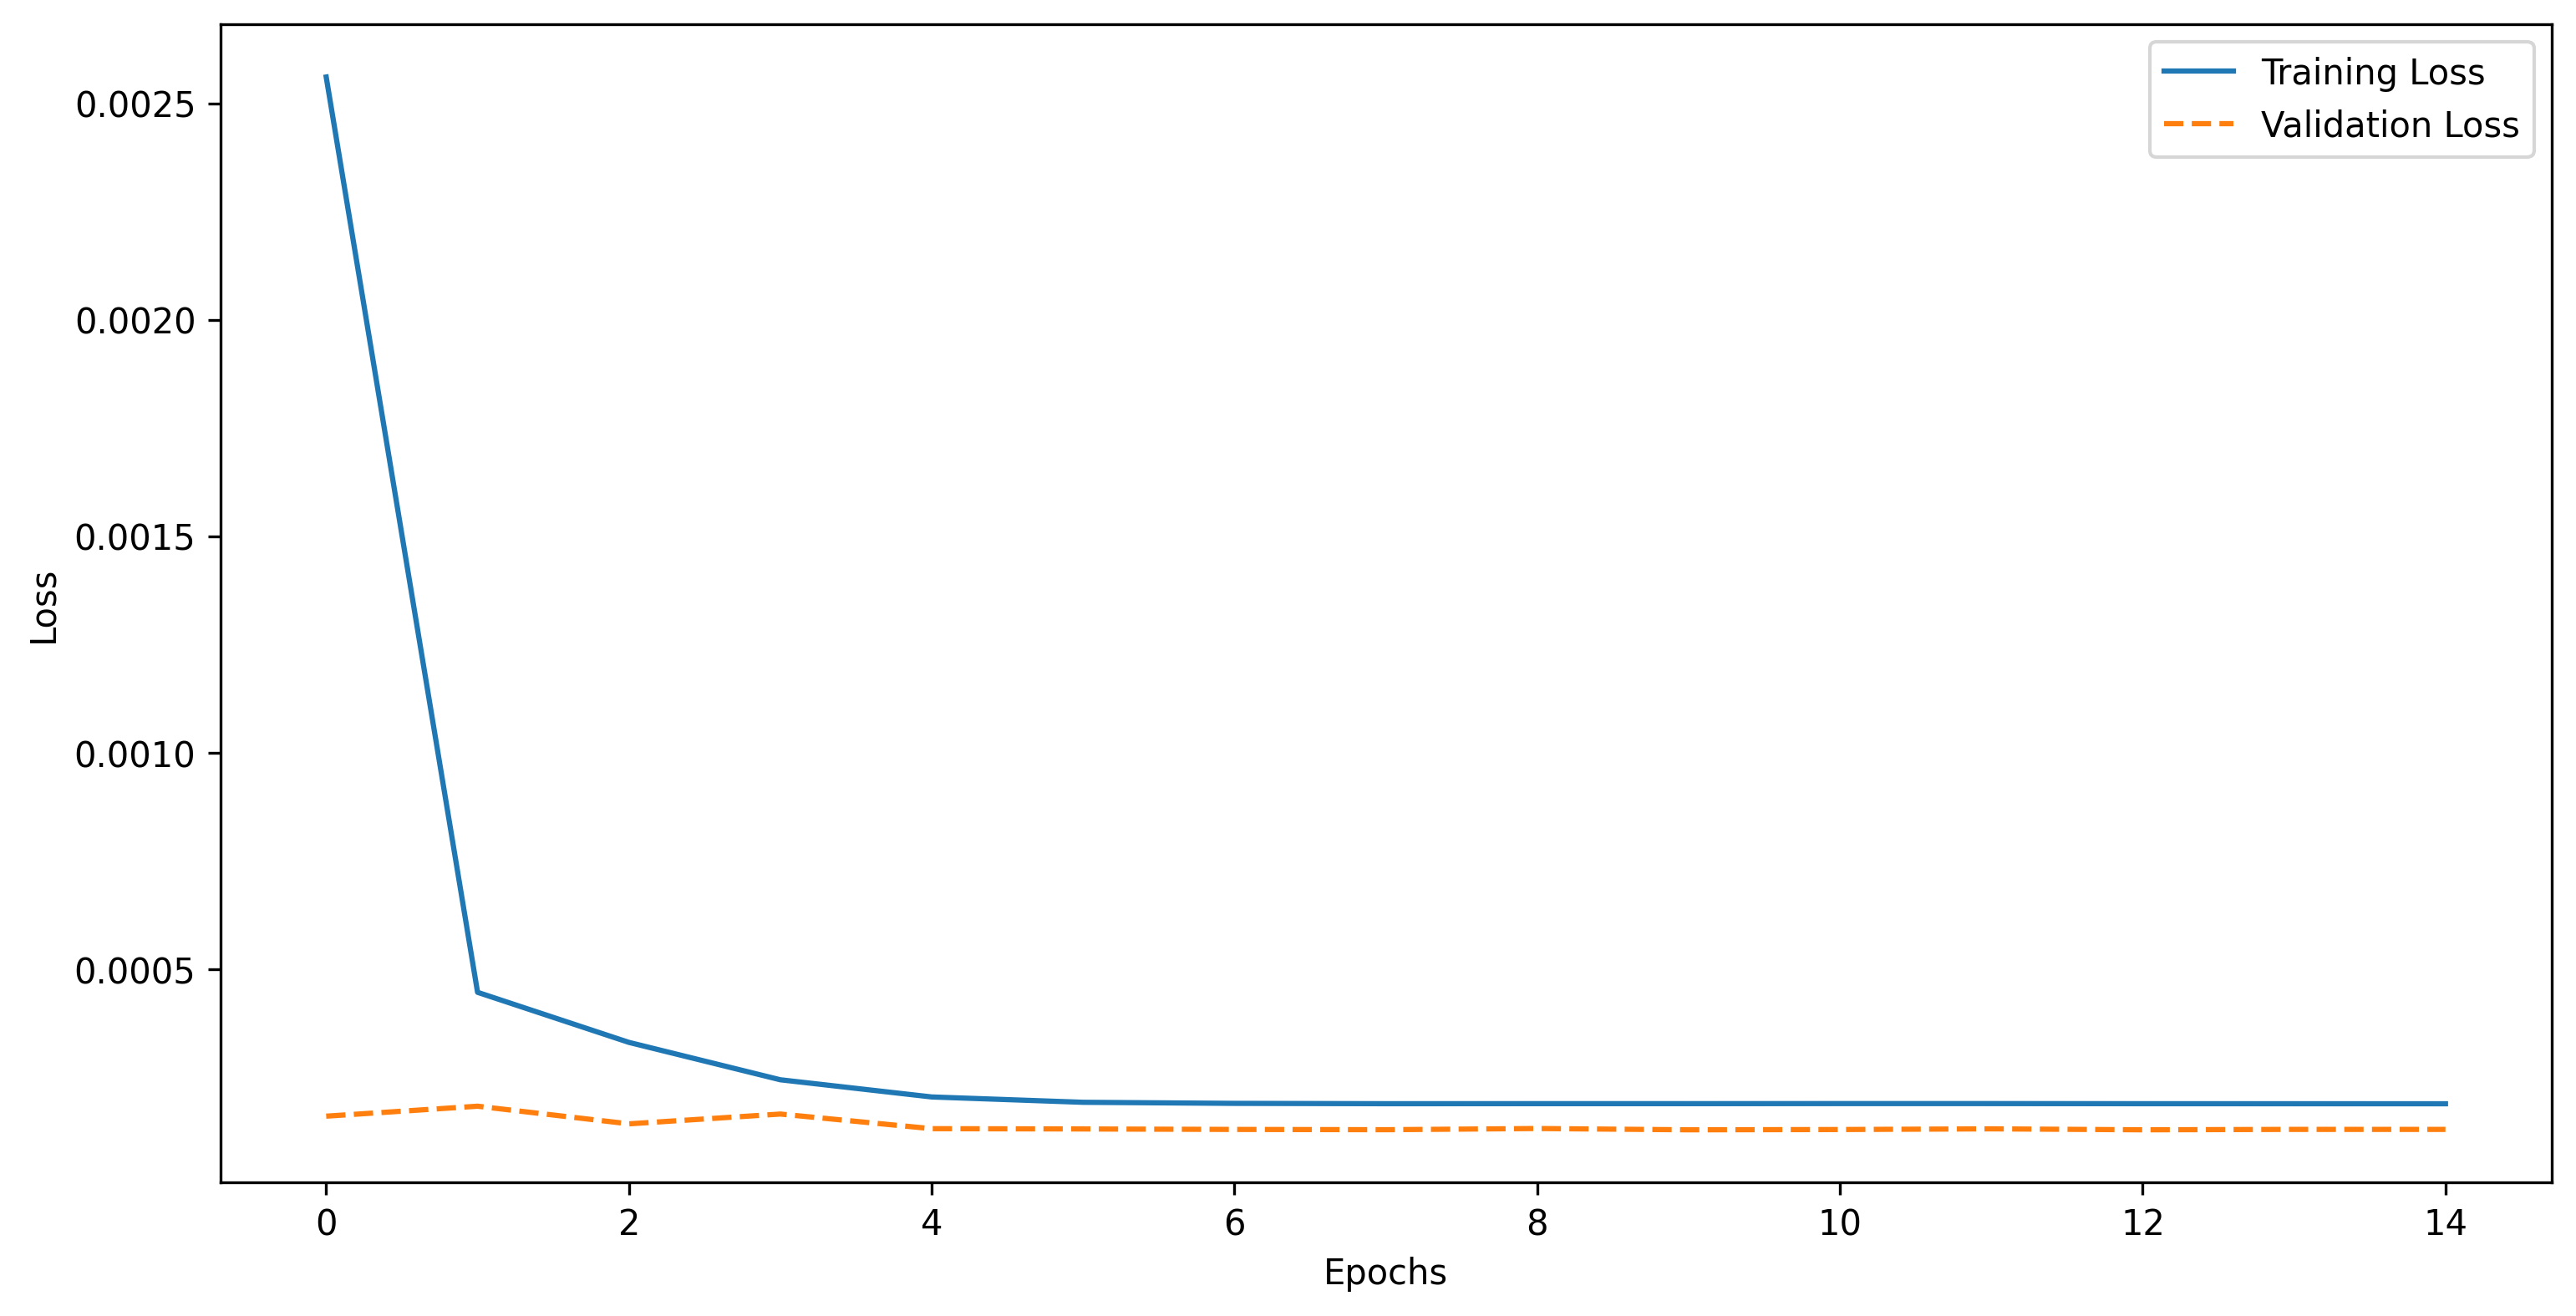

In [ ]:
# Validation set evaluation
predicted_val_inverse, y_val_inverse = inverse_transform_predictions(
    predicted_scaled=final_model.predict(X_val),
    y_actual_scaled=y_val,
    scaler=scaler,
    train_data=train_data,
    target_col_idx=target_col_idx
)

evaluate_forecast(y_val_inverse, predicted_val_inverse, label="GRU - Validation")

# Plot training vs validation loss
# plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

1591/1591 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
GRU - Test MAE: 0.0480
GRU - Test RMSE: 0.0749


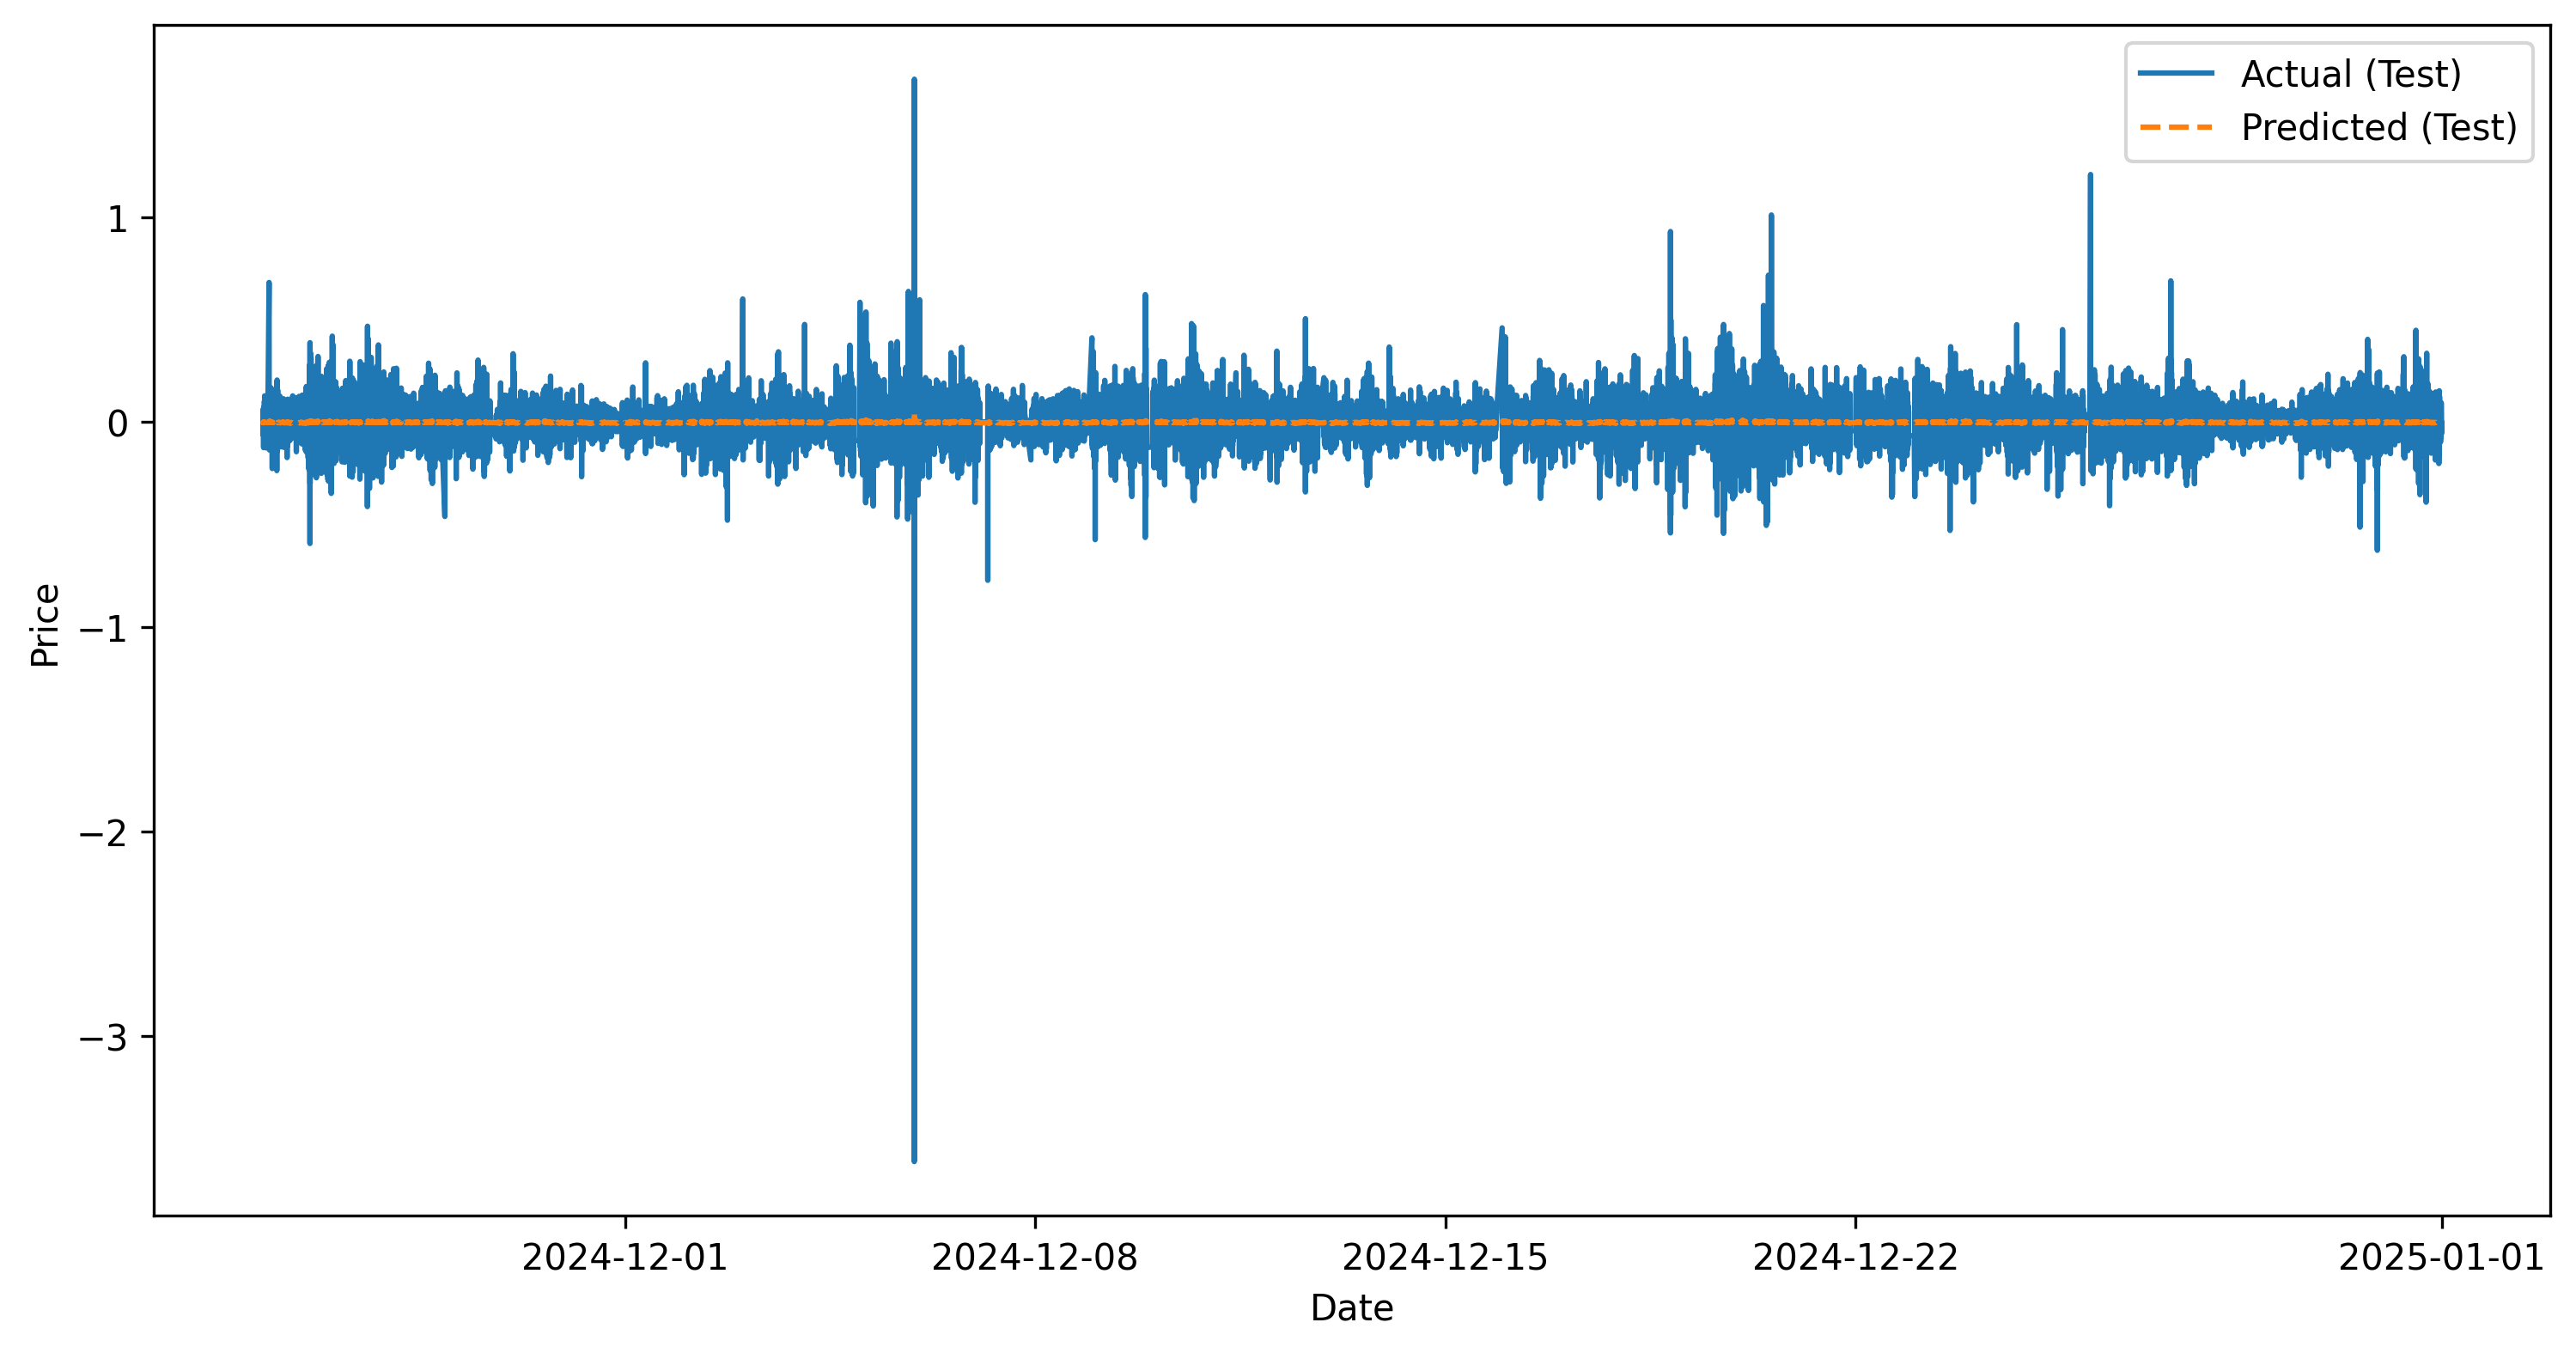

In [ ]:
# Test set evaluation
predicted_test_inverse, y_test_inverse = inverse_transform_predictions(
    predicted_scaled=final_model.predict(X_test),
    y_actual_scaled=y_test,
    scaler=scaler,
    train_data=train_data,
    target_col_idx=target_col_idx
)

evaluate_forecast(y_test_inverse, predicted_test_inverse, label="GRU - Test")

# Plot actual vs predicted Returns% for test set
date_index = test_data.index[WINDOW_SIZE:]
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_inverse, label='Actual (Test)')
plt.plot(date_index, predicted_test_inverse, label='Predicted (Test)', linestyle='dashed')
# plt.title('Actual vs Predicted Returns% (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')

# Show only a few major ticks with full date format
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))  # Adjust the number of shown ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Full date format

# plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Save final model and scaler
import joblib
model_save_path = "/content/drive/My Drive/Colab Notebooks/EMH/models/"
final_model.save(f"{model_save_path}gru_model_best.keras")
joblib.dump(scaler, f"{model_save_path}scaler_best.pkl")

print("\nModel and scaler saved successfully.")


Model and scaler saved successfully.


## Naive Model

In [17]:
train_returns = train_data['Returns%']
val_returns = val_data['Returns%']
test_returns = test_data['Returns%']

combined_train_val = data.iloc[:val_index]['Returns%']

In [18]:
# Calculate mean from the training set for validation forecast
mean_train = train_returns.mean()
benchmark_forecast_val = np.full(shape=len(val_returns), fill_value=mean_train)

print("Mean Benchmark Forecast Performance (Validation):")
evaluate_forecast(val_returns, benchmark_forecast_val, label="Benchmark - Validation")

# For the test set, use the combined training and validation data
mean_combined = combined_train_val.mean()
benchmark_forecast_test = np.full(shape=len(test_returns), fill_value=mean_combined)

print("\nMean Benchmark Forecast Performance (Test):")
evaluate_forecast(test_returns, benchmark_forecast_test, label="Benchmark - Test")

Mean Benchmark Forecast Performance (Validation):
Benchmark - Validation MAE: 0.0412
Benchmark - Validation RMSE: 0.0651

Mean Benchmark Forecast Performance (Test):
Benchmark - Test MAE: 0.0476
Benchmark - Test RMSE: 0.0749
